# Explore the data set

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import *
from pyspark.sql.types import *
from pyspark import SparkConf

import pyspark.sql.functions as F

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
spark = SparkSession \
        .builder \
        .appName("SuperMarket Data Exploration") \
        .enableHiveSupport() \
        .getOrCreate()

sc = spark.sparkContext

In [5]:
df = spark.sql("""
SELECT *
FROM default.supermarket
""").cache()

df.show(5)

+---------+---------+---------------+--------------+----------+----------+--------+-----+
|SHOP_DATE|SHOP_HOUR|      BASKET_ID|     CUST_CODE|STORE_CODE| PROD_CODE|QUANTITY|SPEND|
+---------+---------+---------------+--------------+----------+----------+--------+-----+
| 20071006|       21|994107800268406|CUST0000153531|STORE00001|PRD0901391|       1| 0.37|
| 20070201|       15|994104300305853|CUST0000219191|STORE00002|PRD0901915|       1| 5.08|
| 20071103|       13|994108200514137|CUST0000526979|STORE00003|PRD0903379|       1| 2.36|
| 20070206|       18|994104400743650|CUST0000913709|STORE00004|PRD0903305|       1|  0.2|
| 20071015|       19|994108000780959|CUST0000961285|STORE00001|PRD0903387|       1| 1.65|
+---------+---------+---------------+--------------+----------+----------+--------+-----+
only showing top 5 rows



### Number of quanity for each basket

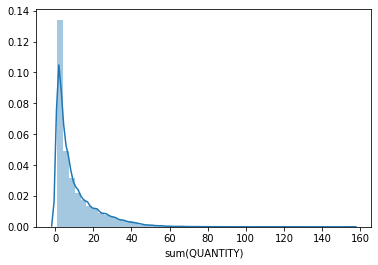

In [6]:
Basket_Quatity = df.select('BASKET_ID', 'QUANTITY') \
                        .groupBy('BASKET_ID') \
                        .sum('QUANTITY')

sns.distplot( Basket_Quatity.toPandas()['sum(QUANTITY)'] )

### Number of transtions for each time

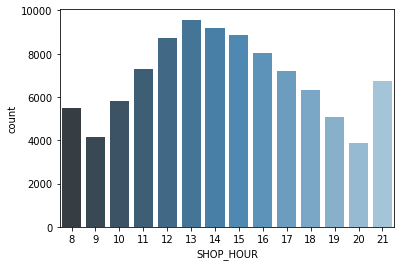

In [7]:
ShopHourCount = df.select("SHOP_HOUR", "BASKET_ID") \
                .distinct() \
                .groupBy("SHOP_HOUR") \
                .count() \
                .orderBy("SHOP_HOUR")

sns.barplot("SHOP_HOUR", y="count", data=ShopHourCount.toPandas(), palette="Blues_d")

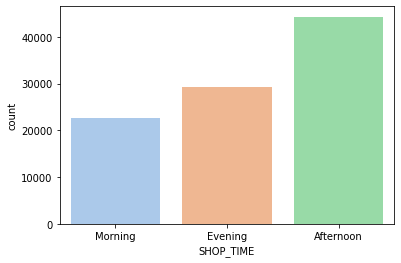

In [8]:
df = df.withColumn("SHOP_TIME", 
                    when( col("SHOP_HOUR") >= 17  , "Evening")
                   .when( col("SHOP_HOUR") >= 12  , "Afternoon")
                   .when( col("SHOP_HOUR") >= 5   , "Morning")
                   .otherwise("Unknown") )

ShopTimeCount = df.select("SHOP_TIME", "BASKET_ID") \
                .distinct() \
                .groupBy("SHOP_TIME") \
                .count() \
                .orderBy("count")

sns.barplot(x="SHOP_TIME", y="count", data=ShopTimeCount.toPandas(), palette="pastel")

### Top most purchased items

In [9]:
Prod_Count = df.select('PROD_CODE', 'QUANTITY') \
            .groupBy('PROD_CODE') \
            .sum() \
            .withColumn("rank", row_number().over(Window.orderBy( col("sum(QUANTITY)").desc() ) ) )

Prod_Count.show(10)

+----------+-------------+----+
| PROD_CODE|sum(QUANTITY)|rank|
+----------+-------------+----+
|PRD0903678|        92694|   1|
|PRD0904358|        15738|   2|
|PRD0903052|        15587|   3|
|PRD0900121|        12861|   4|
|PRD0903269|         7234|   5|
|PRD0901265|         6225|   6|
|PRD0904044|         5728|   7|
|PRD0903130|         5667|   8|
|PRD0900830|         4902|   9|
|PRD0903078|         4825|  10|
+----------+-------------+----+
only showing top 10 rows



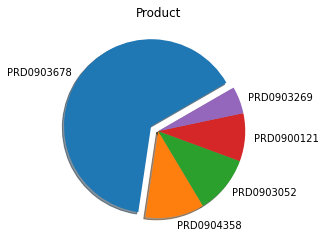

In [10]:
TOP_Prod_Count = Prod_Count.where( col("rank") <= 5 ).toPandas()

plt.pie(
    TOP_Prod_Count['sum(QUANTITY)'], 
    labels = TOP_Prod_Count['PROD_CODE'], 
    startangle = 30,
    shadow = True, 
    explode = (0.1, 0, 0, 0, 0)
)

plt.title('Product')
plt.show()

### Top most purchased items for each stores

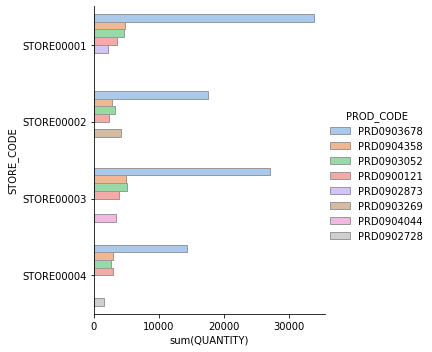

In [11]:
Store_Prod_Count = df.select('STORE_CODE', 'PROD_CODE', 'QUANTITY') \
                    .groupBy('STORE_CODE', 'PROD_CODE') \
                    .sum() \
                    .withColumn("rank", row_number().over(Window.partitionBy("STORE_CODE").orderBy( col("sum(QUANTITY)").desc() ) ) ) \
                    .where( col("rank") <= 5 ) \
                    .orderBy("STORE_CODE", "rank")

sns.catplot(x="sum(QUANTITY)", y="STORE_CODE", hue="PROD_CODE", kind="bar",
            palette="pastel", edgecolor=".6",
            data=Store_Prod_Count.toPandas() )

In [12]:
Num_Of_Bucket_Per_Day = df.select('SHOP_DATE', 'BASKET_ID') \
                        .distinct() \
                        .groupBy('SHOP_DATE') \
                        .count() \
                        .orderBy('SHOP_DATE')
Num_Of_Bucket_Per_Day.show()

+---------+-----+
|SHOP_DATE|count|
+---------+-----+
| 20070101|  133|
| 20070102|  155|
| 20070103|  144|
| 20070104|  150|
| 20070105|  148|
| 20070106|  158|
| 20070107|  143|
| 20070108|  175|
| 20070109|  132|
| 20070110|  179|
| 20070111|  157|
| 20070112|  177|
| 20070113|  189|
| 20070114|  159|
| 20070115|  165|
| 20070116|  163|
| 20070117|  181|
| 20070118|  152|
| 20070119|  164|
| 20070120|  152|
+---------+-----+
only showing top 20 rows

